# Grid Trading Bot 

Build a simple grid trading algorithm, introduce concepts to readers such as Transaction costs, stop losses and order sizing

In [1]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os

from alpha_vantage.foreignexchange import ForeignExchange
import warnings

In [2]:
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
# I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

## Gather FX Historical Data
I will use Alpha vantage to gather historical data, in order for you to collect data yourself, you'll need to create an free account. visit the website
https://www.alphavantage.co/ and follow the instructions there. <br>
<br>
It's never a good practice to copy your credentials as free text into your code.
I've placed my credentials in a .env file which stays with me locally.

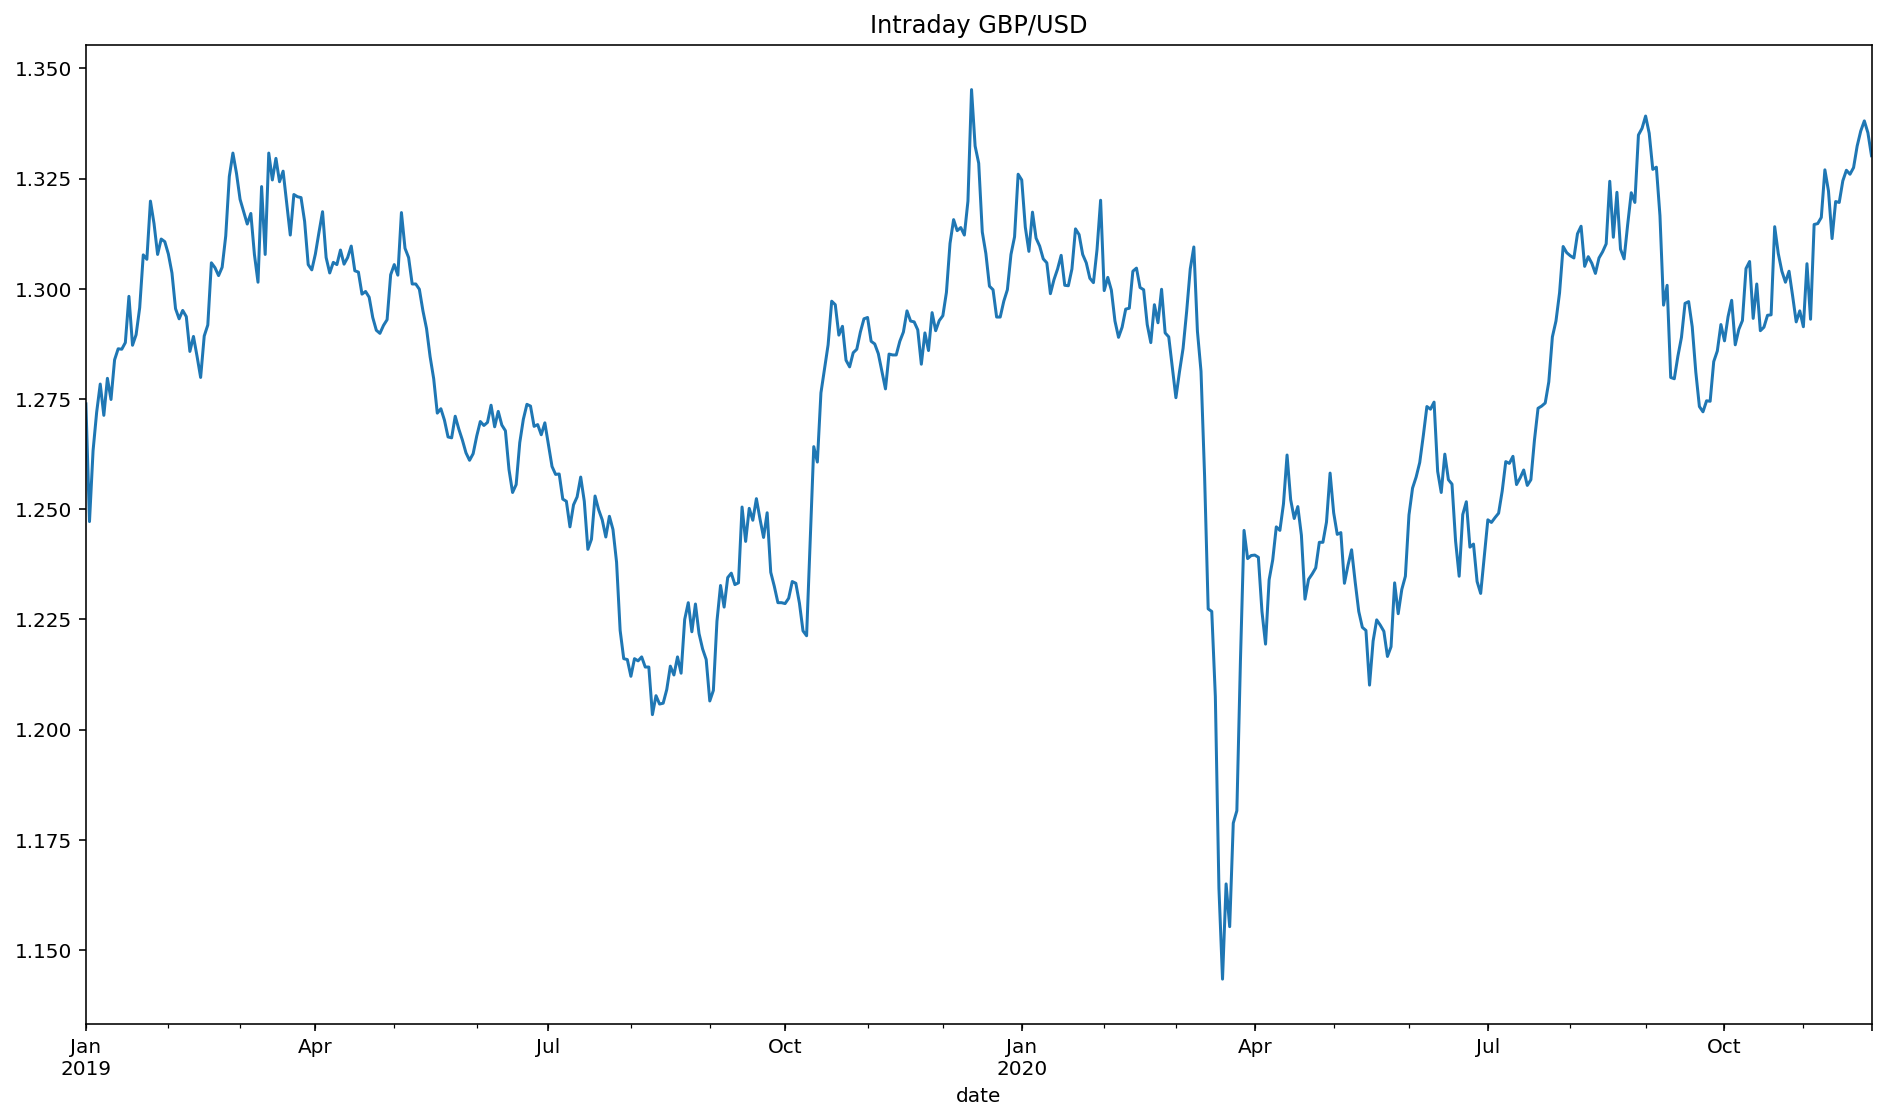

In [3]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')

# We will retreive daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')

# Let's just look at 2015 onwards 

data_df.sort_index(inplace=True)
data_df = data_df.loc['2019-01-01':]

# Plot the results to ensure everything worked

data_df['4. close'].plot()
plt.title('Intraday GBP/USD')
plt.show()

In [4]:
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

# Algorithm Strategy Definition 
To do the backtesting, we will use the Backtrader Python package https://www.backtrader.com/. It's a bigger learning curve to compared to other platforms such as Quantopian, but I really enjoy the added flexibility and the fact you can easily integrate with other Python packages/platforms.

In [199]:
class grid_bander(bt.Strategy):
# set 

    params = dict(
        bands=4
        ,spread=0.02
        ,periods=25)
    
    def __init__(self):
        
        self.mva = bt.ind.ExponentialMovingAverage(self.data.close,period=self.p.periods ,plot=True, plotname='Simple Moving Average', subplot=False)
        
        # Against the grid 
        self.increase_sig = self.data.close > self.data.close(-1)
        self.decrease_sig = self.data.close < self.data.close(-1)
        


    def next(self):
        
        if not self.position:  # not in the market
            if self.increase_sig > 0 and self.data.close > 0:  # TODO - if fast crosses slow to the upside
                self.order_target_percent(target=0.4)   # positive: enter Long, negative: enter Short
                
        elif self.decrease_sig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

## Run the strategy over the last 5 years 

In [200]:
%%time

cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
#risky risky
#cerebro.broker.setcommission(commission=0.00, leverage=20)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(grid_bander)
results = cerebro.run()

CPU times: user 219 ms, sys: 3.37 ms, total: 222 ms
Wall time: 222 ms


Sharpe: 3.579
Norm. Annual Return: 3.47%
Max Drawdown: 1.80%


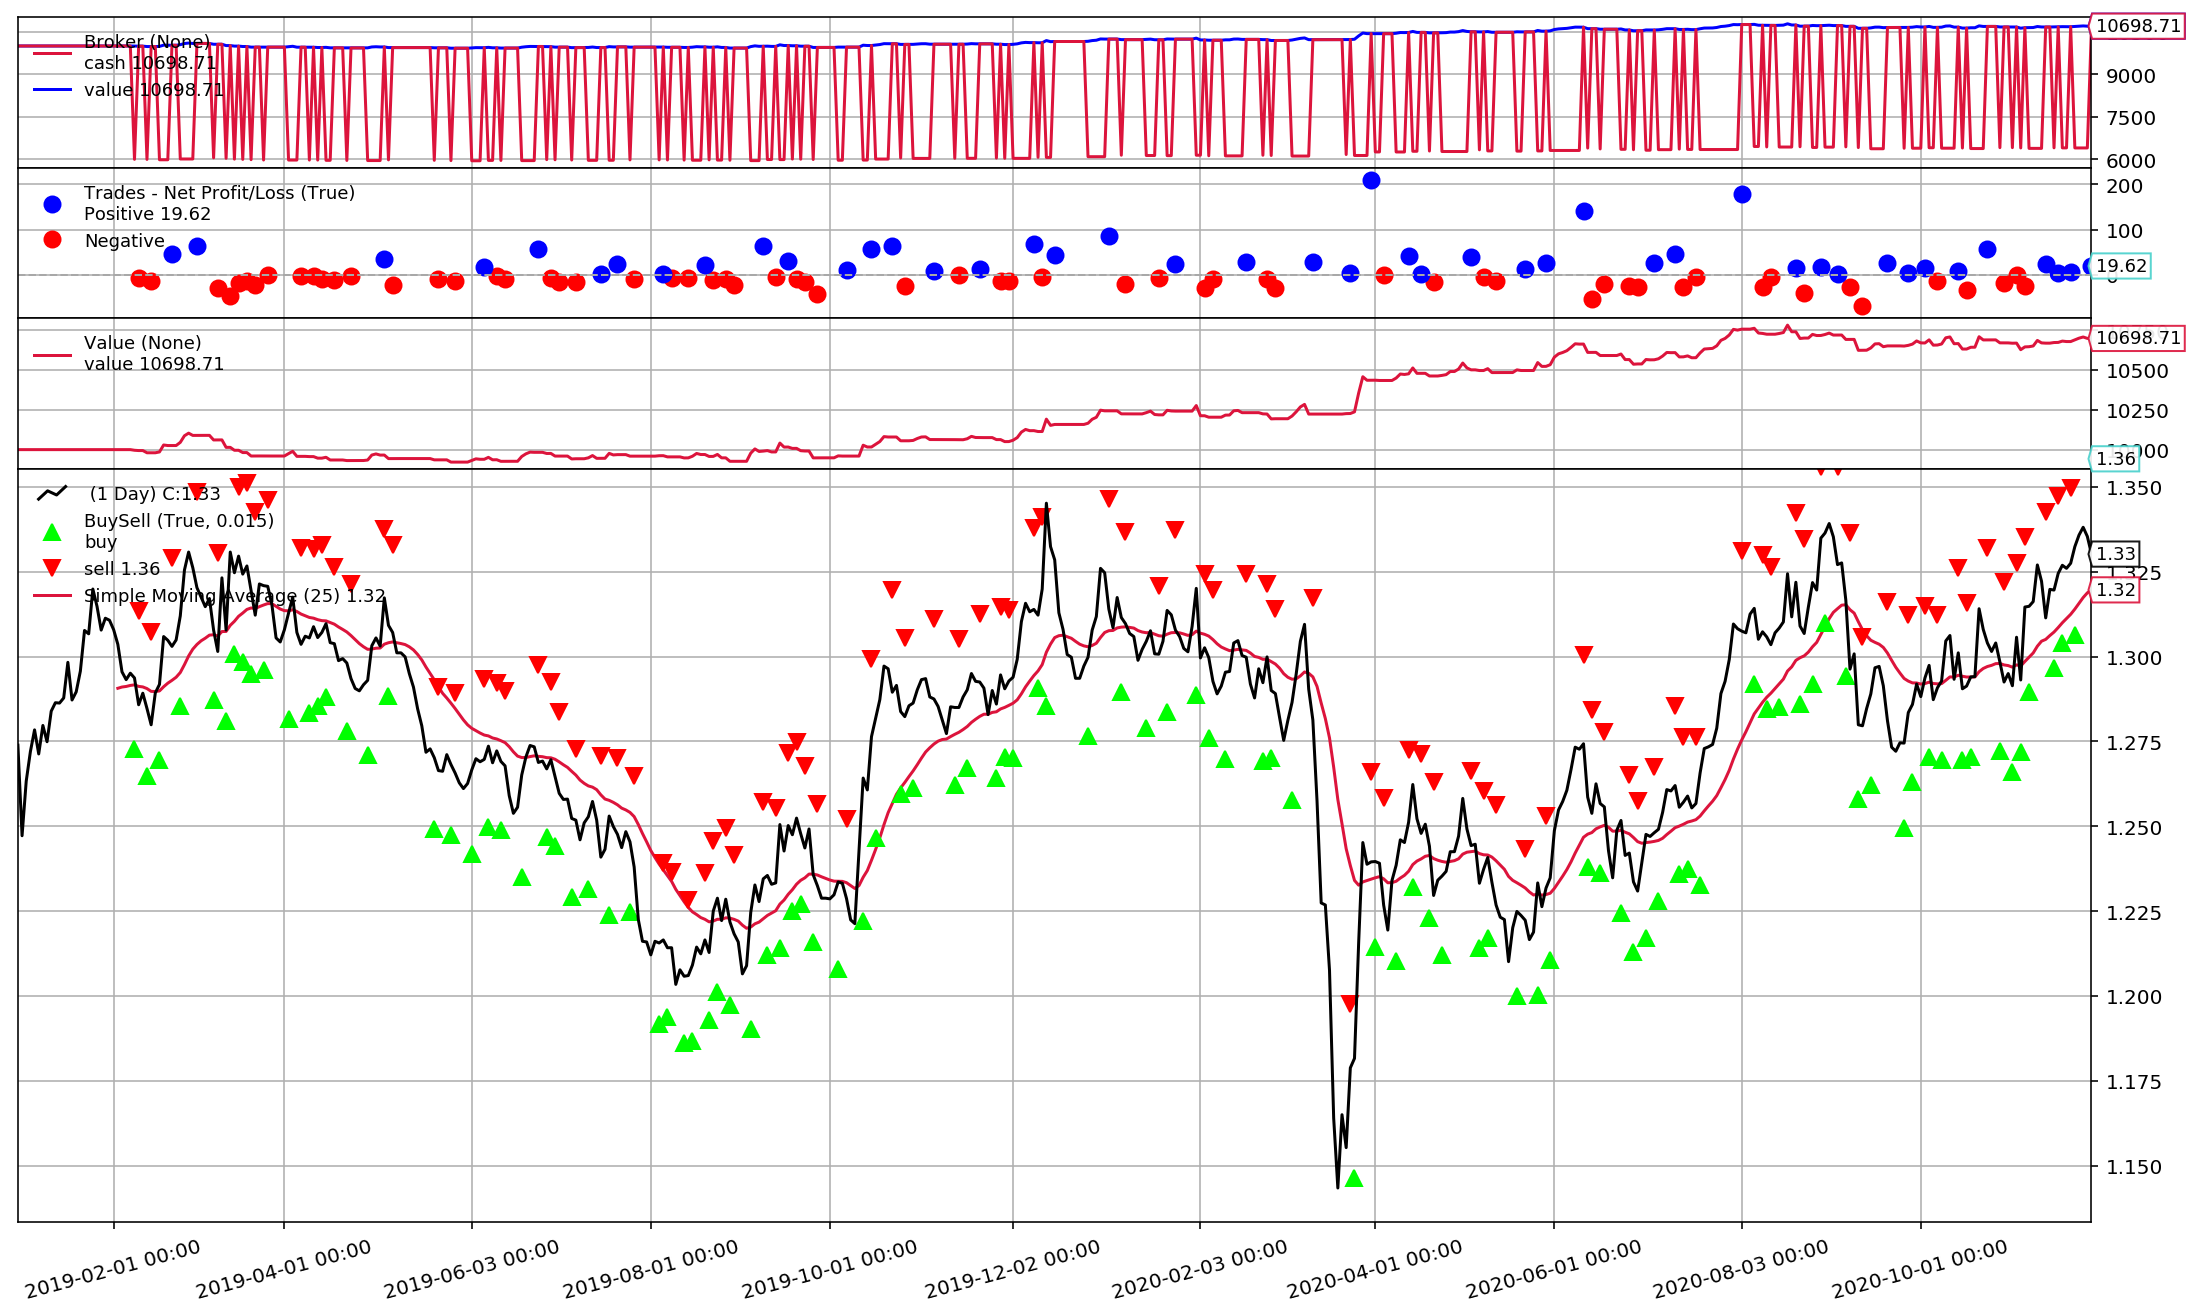

[[<Figure size 1152x648 with 4 Axes>]]

In [201]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=False, volume=False, width=20, style='line')